## In this notebook we'll parse CSV statement from Bank of america and try to visualize spending

### let's download a CSV statement from Bank Of America website

1. open transactions list and click 'download'
![bofa step1](docs/images/bofa_download_step1.png "Bofa download step 1")

2. select "Microsoft Excel format"
![bofa step2](docs/images/bofa_download_step2.png "Bofa download step")

### reading CSV statement into a list of plain dicts.

In [1]:
import pandas as pd

raw_df = pd.read_csv('bofa_sample_february.csv')

### Pre-process data, just cleanup

1. change field names. what we want is 'date', 'description', 'ref_num', 'amount', 'address'
2. change value types - amount is decimal and date is datetime.

In [2]:
columns_meta = {
    'Transaction Date#Post Date#Description#Category#Type#Amount': pd.read_csv('configs/chase_columns.csv'),
    'Posted Date#Reference Number#Payee#Address#Amount': pd.read_csv('configs/bofa_columns.csv'),
}

list(columns_meta.values())[0].head(1)

,source_name,target_name,type,description
0,Transaction Date,tx_date,datetime,date of the transaction


In [3]:
columns_meta_key = '#'.join(raw_df.columns)
columns_df = columns_meta[columns_meta_key]

### 1 rename columns to standard names using metadata provided.

In [4]:
rename_map = {}
for index, row in columns_df.iterrows():
    rename_map[row['source_name']] = row['target_name']
df = raw_df.rename(columns=rename_map)

### 2 now when we have clean names, we can type cast and clean the data.

In [5]:
df['date'] = pd.to_datetime(df['date'])
df['amount'] = df['amount'].astype(float)
df['description'] = df['description'].str.lower().str.replace('\s+',' ', regex=True).str.strip()
df['address'] = df['address'].str.lower().str.replace('\s+',' ', regex=True).str.strip().fillna('###')
df.loc[df['amount'] > 0, 'type'] = 'credit' 
df.loc[df['amount'] < 0, 'type'] = 'debit'

example data

In [6]:
df['description'][4]

'philz coffee www.philzcoffca'

more clean up.

3. clean description, in many cases 'address' is also written in 'description'.

In [7]:
def clean_description_from_address(tx):
    """See lots of transactions where Address is also appended to the description. Let's remove that."""
    address = tx["address"]
    description = tx['description']
    if description.startswith("sq *"):
        description = description.replace("sq *", "")
    #print(address, description)
    if not address:
        return description
    address_without_spaces = address.replace(' ', '')
    description_without_spaces = description.replace(' ', '')
    if description_without_spaces.endswith(address_without_spaces):
        # need to remove address from payee
        # possibilities are:
        # sunnyvale CA -> SunnyvaleCA
        # mountain view ca -> mountain viewca
        # sunnyvale ca -> sunnyvale ca
        if description.endswith(address):
            #print("remove full address")
            return description.replace(address, '').strip()
        k = address.rfind(" ")
        address_without_last_space = address[:k]  + address[k+1:]
        #print(address_without_last_space)
        if description.endswith(address_without_last_space):
            #print("remove partial address")
            #print(description.replace(address_without_last_space, '').strip())
            return description.replace(address_without_last_space, '').strip()
    #print(description)
    return description

In [8]:
df['description'] = df.apply(clean_description_from_address, axis=1)

example cleaned data

In [9]:
df['description'][4]

'philz coffee'

### 2. try to infer merchant and category

for that for now we do mostly regex matching.
as this list grows it will be moved to the database.

for now config for how to map description to merchant and tags is in 

`description_matchers.json` file

In [10]:
matchers_category = pd.read_csv('configs/matchers_category.csv')
matchers_merchant = pd.read_csv('configs/matchers_merchant.csv')
merchants = pd.read_csv('configs/merchants.csv').set_index('merchant')
categories = pd.read_csv('configs/categories.csv').set_index('category')
categories['parent'] = categories['parent'].fillna('')

In [11]:
import re
def find_merchant(description):
    for index, matcher in matchers_merchant.iterrows():
        operation = matcher["operation"]
        expression = matcher["expression"]
        merchant = matcher["merchant"]
        if operation == "exact":
            if description == expression:
                return merchant, {}
        elif operation == "keyword":
            parts = re.split(' |\.|,|\n', description)
            if expression in parts:
                return merchant, {}
        elif operation == "regex":
            re_match = re.match(expression, description)
            if re_match:
                extra_values = {}
                if re_match.groupdict():
                    assign_values = re_match.groupdict()
                return merchant, extra_values
    return None, {}

def find_category(description):
    for index, matcher in matchers_category.iterrows():
        operation = matcher["operation"]
        expression = matcher["expression"]
        category = matcher["category"]
        if operation == "exact":
            if description == expression:
                return category
        elif operation == "keyword":
            parts = re.split(' |\.|,|\n', description)
            if expression in parts:
                return category
        elif operation == "regex":
            re_match = re.match(expression, description)
            if re_match:
                extra_values = {}
                if re_match.groupdict():
                    assign_values = re_match.groupdict()
                return category
    return None

def find_merchant_category(merchant):
    return merchants.loc[merchant]['category']

def find_root_category(category):
    parent = categories.loc[category]["parent"]
    if parent:
        return find_root_category(parent)
    else:
        return category

In [12]:
find_merchant_category('anthropologie')

'clothing'

In [13]:
find_root_category('clothing')

'shopping'

In [14]:
find_category('something toys something')

'toys'

In [15]:
find_merchant('coupa cafe palo alto')

('coupa cafe', {})

In [16]:
def parse_description(description):
    merchant, extra_values = find_merchant(description)
    if merchant:
        category = find_merchant_category(merchant)
    else:
        category = find_category(description)
    if not category:
        category = "uncategorized"
    root_category = find_root_category(category)
    return dict(
        merchant=merchant,
        category=category,
        root_category=root_category,
        **extra_values
    )

def enhance_transaction(tx):
    values_to_add = parse_description(tx["description"])
    if values_to_add:
        if "merchant" not in values_to_add:
            # TBD if this is what we want
            values_to_add["merchant"] = tx["description"]
        for k, v in values_to_add.items():
            tx[k] = v
    return tx

df = df.apply(enhance_transaction, axis=1)

example labeled data

In [17]:
df.loc[4]

date                   2020-02-10 00:00:00
ref_num          1234566780039637129230449
description                   philz coffee
address                   www.philzcoff ca
amount                               -3.67
type                                 debit
merchant                      philz coffee
category                       coffee_shop
root_category                         food
Name: 4, dtype: object

### 3. now all is categorized, let's try to slice and dice

#### Daily spendings for a month

<BarContainer object of 31 artists>

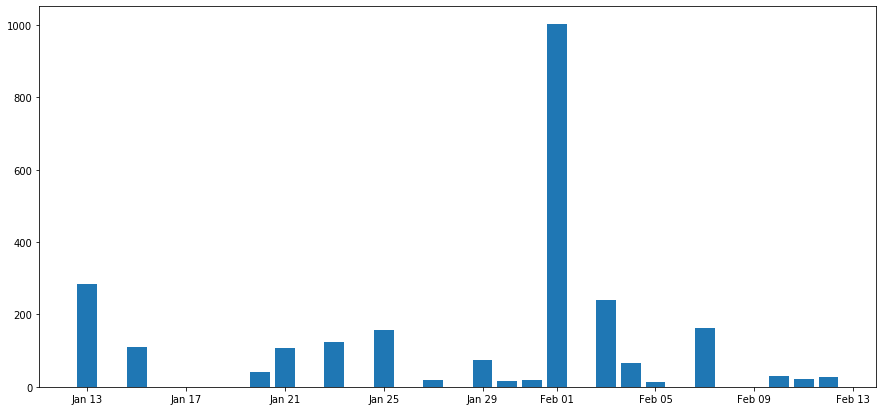

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = df.set_index('date')
fig, ax = plt.subplots(figsize=(15,7))

daily_spendings_df = df[df['type']=='debit'].resample('D').sum().transform(abs)
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
daily_spendings_df
ax.bar(daily_spendings_df.index, daily_spendings_df['amount'])

#### Spendings by category


**Pie chart view**

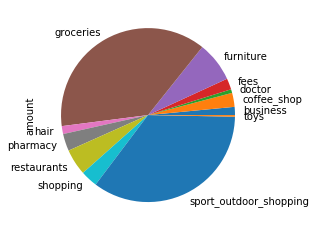

In [19]:
df[df['type']=='debit'].groupby(['category'])['amount'].agg('sum').map(abs).plot(kind='pie')

**Table View**

In [20]:
df[df['type']=='debit'].groupby(['category'])['amount'].agg('sum').map(abs).sort_values(ascending=False).to_frame().reset_index()

,category,amount
0,groceries,947.51
1,sport_outdoor_shopping,877.93
2,furniture,186.41
3,restaurants,122.41
4,pharmacy,79.97
5,shopping,79.19
6,coffee_shop,65.22
7,fees,51.81
8,business,38.00
9,hair,37.00
